# Testing `pycic`

In [1]:
import numpy as np
import pycic

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Testing `CountMatrix`

In [2]:
# 512 random objects
x = np.random.uniform(0., 500., (512, 3))

# put the objects to a box of length 500 unit
# divide as 4**3 cells 
cm = pycic.CountMatrix(x, 4, 500., )

# count in all cells
cm.countVector()

array([ 5,  4,  5,  8,  7,  6, 12,  5,  9,  7,  3,  6,  9,  8, 10, 15, 10,
        6,  7,  6,  6,  6,  8,  8, 17,  8,  9,  6, 10, 19,  2,  6,  9, 12,
        9, 10, 10,  7,  7,  8,  9,  5,  5, 10,  6,  6,  7,  8,  7,  5, 10,
        6,  8,  5,  6, 12,  5,  9, 11,  9, 11,  7, 11,  9])

## Testing Catalog object: `CartesianCatalog`

In [3]:
# uniform dist. positions in 500 unit box
x = np.random.uniform(0., 500., (512, 3))

# uniform dist. velocity in [-10, 10]
v = np.random.uniform(-10., 10., (512, 3))

# normally dist. mass 
m = np.random.normal(1.e+5, 5., (512, ))  

# creating the catalog:
cat = pycic.CartesianCatalog(x, v, mass = m, redshift = 0.)
cat

<'CartesianCatalog' of 512 objects>

## Testing CIC Distribution, `cicDistribution`

In [2]:
import lss2

# cosmology object to get power spectrum
cs = lss2.CosmoStructure(Om0 = 0.3, Ob0 = 0.05, sigma8 = 0.8, n = 1., h = 0.7, psmodel = "eisenstein98_zb")

k = np.logspace(-6, 6, 201)
pk = cs.matterPowerSpectrum(k, 0.)

cd = pycic.cicDistribution(
                            np.log(np.stack([k, pk], axis = -1)), # power table
                            0.,                          # redshift
                            cs.Om0, cs.Ode0, cs.h, cs.n, # cosmology param.
                            1.95                         # cellsize
                           )

cd

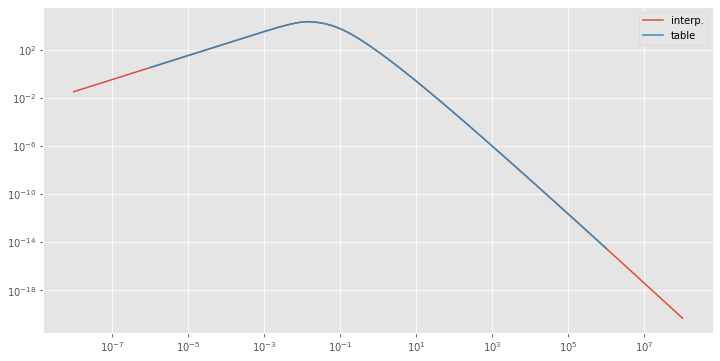

In [5]:
# testing power spectrum:

k1 = np.logspace(-8, 8, 501)
fk = cd.powerLin(np.log(k1))

plt.figure(figsize = (12, 6))
plt.loglog()
plt.plot(k1, fk, label = "interp.")
plt.plot(k, pk, label = "table")
plt.legend()
plt.show()


In [6]:
# variance/bias calculation:

vlin = cd.varLin()
print("linear var. = ", vlin)
print("A var.      = ", cd.varA(vlin)) 
print("bias        = ", cd.biasA(vlin))

linear var. =  5.401181426146088
A var.      =  1.5535116894967078
bias        =  0.5363062769370961


## Test : Calculation of $P_{A, meas}(\bf k)$

For $\vert \bf k \vert \le k_N$, power is given bu 

$$ P_{A, meas} (\bf k) = P_A(\bf k + 2k_N \bf n) \cdot W(\bf k + 2k_N \bf n) $$

where $W(\bf k)$ is the mass assignment function and $\bf n$ is a vector of 3 integers, with length less than 3. For other k-vectors, a power law continuation is used. 

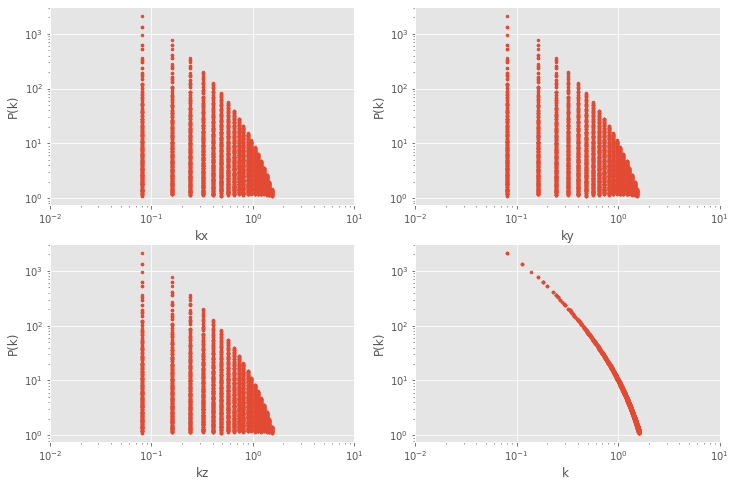

In [38]:
# measured power

from itertools import product, repeat
kvec = np.asarray(list(product(*repeat(np.linspace(1e-6, cd.kn, 21), 3))))

k    = np.sqrt(np.sum(kvec**2, axis = 1))

# power eqn valid for norm(k) <= kn only
mask = np.where(k <= cd.kn)[0]
kvec = kvec[mask, :]
k    = k[mask]

pk_a = cd._powerA_meas(kvec[:,0], kvec[:,1], kvec[:,2])

fig, axs = plt.subplots(2, 2, figsize = [12, 8])
for ax, __k, __klab in zip(axs.flatten(), [*kvec.T, k], "xyz "):
    ax.loglog()
    ax.plot(__k, pk_a, '.', ms = 5)
    ax.set_xlim([1e-2, 1e+1])
    ax.set_xlabel("k" + __klab)
    ax.set_ylabel("P(k)")

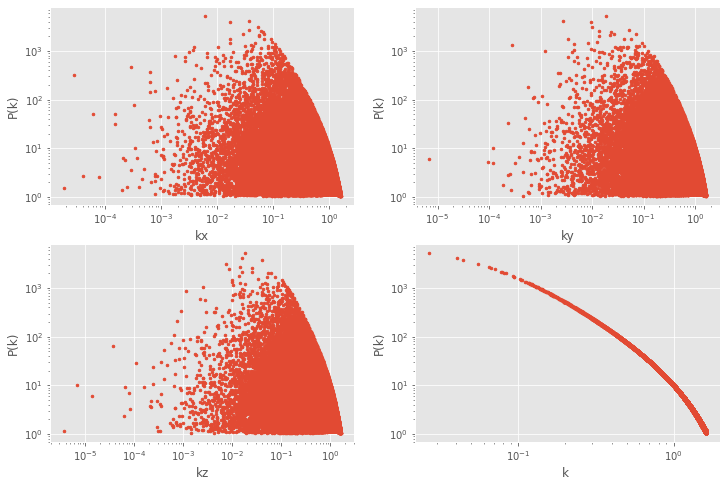

In [41]:
kvec = np.exp(np.random.uniform(0., np.log(cd.kn), (100000, 3)))

k    = np.sqrt(np.sum(kvec**2, axis = 1))

# power eqn valid for norm(k) <= kn only
mask = np.where(k <= cd.kn)[0]
kvec = kvec[mask, :]
k    = k[mask]

pk_a = cd._powerA_meas(kvec[:,0], kvec[:,1], kvec[:,2])

fig, axs = plt.subplots(2, 2, figsize = [12, 8])
for ax, __k, __klab in zip(axs.flatten(), [*kvec.T, k], "xyz "):
    ax.loglog()
    ax.plot(__k, pk_a, '.', ms = 5)
    # ax.set_xlim([1e-2, 1e+1])
    ax.set_xlabel("k" + __klab)
    ax.set_ylabel("P(k)")